## Training

In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random
from tqdm import tqdm
import time
import sys, os
from sklearn.model_selection import GridSearchCV
#from os.path import pardir, sep 
sys.path.insert(1,'/'+os.path.join(*os.getcwd().split('/')[:-2]))
from pipeline.custom_models import SIR_fitter, SIR_predictor
from pipeline.utils import *

### Copy the data locally

In [2]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [3]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
#urllib.request.urlretrieve(DATA_URL, DATA_FILE)

In [4]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [5]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [6]:
# For testing, restrict training data to that before a hypothetical predictor submission date
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-10-15")
df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [7]:
df=create_dataset(df,drop=False)

In [8]:
# Keep only columns of interest
id_cols = ['CountryName',''
           'RegionName',
           'GeoID',
           'Date']
# Columns we care just about the last value (usually it's always the same value for most of them)
adj_cols_fixed=['ConfirmedCases', 'Population']#,
       #"Population Density (# per km2)",
       #"Urban population (% of total population)",
       #"Population ages 65 and above (% of total population)",
       #"GDP per capita (current US$)", "Obesity Rate (%)", "Cancer Rate (%)",
       #"Share of Deaths from Smoking (%)", "Pneumonia Death Rate (per 100K)",
       #"Share of Deaths from Air Pollution (%)",
       #"CO2 emissions (metric tons per capita)",
       #"Air transport (# carrier departures worldwide)"]

# Columns we would like to include for the last nb_lookback days
adj_cols_time=['TemperatureC']


cases_col = ['MA']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']


In [9]:
# Fill also missing CONFIRMED case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').ConfirmedCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [10]:
#df['PastCases']=df.ConfirmedCases.values

In [11]:
df.columns

Index(['CountryName', 'CountryCode', 'Population',
       'Population Density (# per km2)',
       'Urban population (% of total population)',
       'Population ages 65 and above (% of total population)',
       'GDP per capita (current US$)', 'Obesity Rate (%)', 'Cancer Rate (%)',
       'Share of Deaths from Smoking (%)', 'Pneumonia Death Rate (per 100K)',
       'Share of Deaths from Air Pollution (%)',
       'CO2 emissions (metric tons per capita)',
       'Air transport (# carrier departures worldwide)', 'RegionName',
       'RegionCode', 'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_

In [12]:
# Keep only columns of interest
df = df[id_cols+ cases_col  +adj_cols_fixed+ adj_cols_time+ npi_cols]

In [13]:
df.count()

CountryName                             59214
RegionName                              20448
GeoID                                   59214
Date                                    59214
MA                                      59214
ConfirmedCases                          59214
Population                              59214
TemperatureC                            59214
C1_School closing                       59214
C2_Workplace closing                    59214
C3_Cancel public events                 59214
C4_Restrictions on gatherings           59214
C5_Close public transport               59214
C6_Stay at home requirements            59214
C7_Restrictions on internal movement    59214
C8_International travel controls        59214
H1_Public information campaigns         59214
H2_Testing policy                       59214
H3_Contact tracing                      59214
H6_Facial Coverings                     59214
dtype: int64

In [14]:
#df=df[df['CountryName'].isin(['Italy','Germany','Spain','France'])].sort_values(
#    ['GeoID','Date'])

In [15]:
df.loc[df.MA<0,'MA']=0.

In [16]:
lookback_days=30

X_samples, y_samples= skl_format(df,True,lookback_days,adj_cols_fixed,adj_cols_time,
                                True)
print(X_samples.shape)
print(y_samples.shape)

(50596, 423)
(50596,)


In [51]:
np.array([[1,4,3],[10,10,10]])[0,0:2].sum()

5

In [57]:
X_samples[100,lookback_days-3:lookback_days+1]

array([ 205.28571429,  212.85714286,  224.57142857, 4042.        ])

In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_samples,
                                                    y_samples,
                                                    test_size=0.2,
                                                    random_state=301)

In [18]:
#md_str="MultiTaskLassoCV(alphas=[1e-5,1e-6,1e-7], normalize=True,  max_iter=500000, tol=1e-5,  cv=3, verbose=False, n_jobs=26,selection='random')"
#md_str="Lasso(alpha=0.00001,normalize=True,max_iter=100000,tol=1e-5)"
md_str="MultiOutputRegressor(xgb.XGBRegressor(n_estimators=10,max_depth=2,learning_rate=0.05,gamma=0.1,subsample=.5,n_jobs=24))"
s_t=time.time()
SP=SIR_predictor(df,moving_average=True,lookback_days=lookback_days,infection_days=7,
                 semi_fit=7,MLmodel=md_str,nprocs=26)
SP.fit(X_train,y_train);
print(SP.TMAE)
e_t=time.time()-s_t
print('Elapsed time: {} min'.format(e_t/60))

Fitting SIR parameters...


100%|██████████| 278/278 [02:40<00:00,  1.74it/s]


0.2417119586959961
Elapsed time: 2.7158955415089925 min


In [18]:
param_grid={'semi_fit':[3,7]}
gcv = GridSearchCV(estimator=SIR_predictor(df,moving_average=True,lookback_days=lookback_days,infection_days=7,
                 semi_fit=7,nprocs=26),
                           param_grid=param_grid,
                           scoring=None,  # TODO
                           n_jobs=1,      # -1 is ALL PROCESSOR AVAILABLE
                           cv=2,          # None is K=5 fold CV
                           refit=True,
                   verbose=1
                           )

        # Fit the GridSearch
gcv.fit(X_train, y_train);

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Fitting SIR parameters...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
100%|██████████| 4/4 [00:07<00:00,  1.93s/it]


Fitting SIR parameters...


100%|██████████| 4/4 [00:07<00:00,  1.98s/it]


Fitting SIR parameters...


100%|██████████| 4/4 [00:11<00:00,  2.82s/it]


Fitting SIR parameters...


100%|██████████| 4/4 [00:12<00:00,  3.00s/it]


Fitting SIR parameters...


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   46.3s finished
100%|██████████| 4/4 [00:11<00:00,  2.78s/it]


GridSearchCV(cv=2,
             estimator=SIR_predictor(df=      CountryName RegionName        GeoID       Date           MA  \
21300      France        NaN  France__nan 2020-01-01     0.000000   
21301      France        NaN  France__nan 2020-01-02     0.000000   
21302      France        NaN  France__nan 2020-01-03     0.000000   
21303      France        NaN  France__nan 2020-01-04     0.000000   
21304      France        NaN  France__nan 2020-01-05     0.000000   
...           ...        ...          ...        ...          ...   
40891       Spain        NaN   Spain__nan 2020-07-27  1992.2...
40894                               3.0                              2.0   
40895                               3.0                              2.0   

       H2_Testing policy  H3_Contact tracing  H6_Facial Coverings  
21300                0.0                 0.0                  0.0  
21301                0.0                 0.0                  0.0  
21302                0.0             

In [19]:
gcv.cv_results_

{'mean_fit_time': array([ 8.62181306, 12.57688367]),
 'std_fit_time': array([0.06650543, 0.31030929]),
 'mean_score_time': array([0.99651647, 0.96222925]),
 'std_score_time': array([0.008986  , 0.00780773]),
 'param_semi_fit': masked_array(data=[3, 7],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'semi_fit': 3}, {'semi_fit': 7}],
 'split0_test_score': array([168.66087014, 209.86607583]),
 'split1_test_score': array([163.11939674, 155.52000058]),
 'mean_test_score': array([165.89013344, 182.6930382 ]),
 'std_test_score': array([ 2.7707367 , 27.17303762]),
 'rank_test_score': array([2, 1], dtype=int32)}

In [19]:
y_train_pred=SP.predict(X_train)

In [20]:
mae(y_train_pred,y_train)

21.32867851174195

In [21]:
mae(SP.predict(X_test),y_test)

22.48780986770212

In [27]:
y_train[0:10]

array([0.00000000e+00, 2.03600000e+03, 0.00000000e+00, 7.14285714e-01,
       0.00000000e+00, 9.00000000e+00, 2.28571429e+00, 1.38571429e+01,
       3.81428571e+01, 5.00000000e+00])

In [26]:
SP.predict(X_train[0:10,:])

[0.0,
 1994.9548834125198,
 0.14302787452108665,
 0.8603136810283182,
 0.0,
 10.30520839792953,
 2.4380378125194766,
 14.643172599162547,
 31.83987107403651,
 5.300039171522395]

In [22]:
SP.predict_pars(X_train)[0:10,:]

array([[0.38157627, 0.38038185],
       [0.38082063, 0.37566823],
       [0.38157627, 0.38038185],
       [0.3816745 , 0.3772719 ],
       [0.37937906, 0.37857392],
       [0.38016394, 0.37823153],
       [0.38016394, 0.37625638],
       [0.38016394, 0.3751517 ],
       [0.38113463, 0.3771722 ],
       [0.38308835, 0.38038185]], dtype=float32)

In [23]:
SP.y_pars[:10]

array([[3.18720822e-01, 1.91206775e-01],
       [4.08281425e-01, 2.95418154e-01],
       [3.73115825e-01, 2.67435072e-01],
       [3.66626142e-01, 2.71909790e-01],
       [3.66949594e-01, 2.86671507e-01],
       [3.43472664e-01, 2.66091623e-01],
       [2.73577617e-01, 1.86146613e-01],
       [2.37116013e-01, 1.49166619e-01],
       [1.54331898e-01, 1.77357171e-16],
       [1.56682199e-01, 5.25923201e-18]])

In [ ]:
mae(SP.predict_pars(X_train),SP.y_pars)

## GridSearch Inspection

In [29]:
with open('models/gcv.pkl','rb') as f:
    gcvres=pickle.load(f)


In [30]:
gcvres.keys()        

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_MLmodel', 'param_infection_days', 'param_semi_fit', 'params', 'split0_test_score', 'split1_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [44]:
gcvres['mean_test_score'][np.argmin(gcvres['rank_test_score'])]

-28.54445594185291

In [39]:
gcvres['params'][np.argmin(gcvres['rank_test_score'])]

{'MLmodel': 'MultiOutputRegressor(xgb.XGBRegressor(gamma=0.2,learning_rate=0.1,max_depth=2,n_estimators=10,subsample=1))',
 'infection_days': 7,
 'semi_fit': 7}

### Lasso inspection

In [53]:
# Inspect the learned feature coefficients for the model
# to see what features it's paying attention to.

# Give names to the features
x_col_names = []
#for d in range(-lookback_days, 0):
#    x_col_names.append('Day ' + str(d) + ' ' + cases_col[0])
for col_name in adj_cols_fixed:
        x_col_names.append(col_name)
        
for d in range(-lookback_days, 1):
    for col_name in adj_cols_time:
        x_col_names.append('Day ' + str(d) + ' ' + col_name)
        
for d in range(-lookback_days, 1):
    for col_name in npi_cols:
        x_col_names.append('Day ' + str(d) + ' ' + col_name)

# View non-zero coefficients
print('Impact on beta')
for (col, coeff) in zip(x_col_names, list(SP.MLmodel.coef_[0])):
    if coeff != 0.:
        print(col, coeff)
print('Intercept', SP.MLmodel.intercept_[0])

print('\nImpact on gamma')
for (col, coeff) in zip(x_col_names, list(SP.MLmodel.coef_[1])):
    if coeff != 0.:
        print(col, coeff)
print('Intercept', SP.MLmodel.intercept_[1])

Impact on beta
Day -30 H1_Public information campaigns 0.00010825851361328623
Day -30 H3_Contact tracing 0.00025887159211366787
Day -28 C5_Close public transport 0.00022322186706630326
Day -21 H2_Testing policy -4.784802748295873e-05
Day -19 H6_Facial Coverings -0.00014830049076964573
Day -6 C1_School closing 0.00010126419198229243
Day -3 H1_Public information campaigns 0.00015803079622776515
Day -2 C3_Cancel public events 2.1380398279226194e-05
Day -1 H3_Contact tracing -0.0008375684547906771
Intercept 0.20365789477291188

Impact on gamma
Day -30 H1_Public information campaigns -2.145604656847398e-05
Day -30 H3_Contact tracing 0.00018040254474102776
Day -28 C5_Close public transport 0.0002746245692335019
Day -21 H2_Testing policy -0.0006859268134565876
Day -19 H6_Facial Coverings -0.0001372356620346198
Day -6 C1_School closing 7.41888328021661e-05
Day -3 H1_Public information campaigns 0.00016148191884050335
Day -2 C3_Cancel public events 5.789837551585999e-05
Day -1 H3_Contact tracin

# Results

In [13]:
df_res=pd.read_csv('pipe_RFC/data/predictions.csv')
df_res=df_res[df_res.CountryName=='Italy']
train_lim=[i for i in df_res.index 
           if df_res.iloc[i,:]['Date'] =='2020-11-15'][0]
print(train_lim)

259


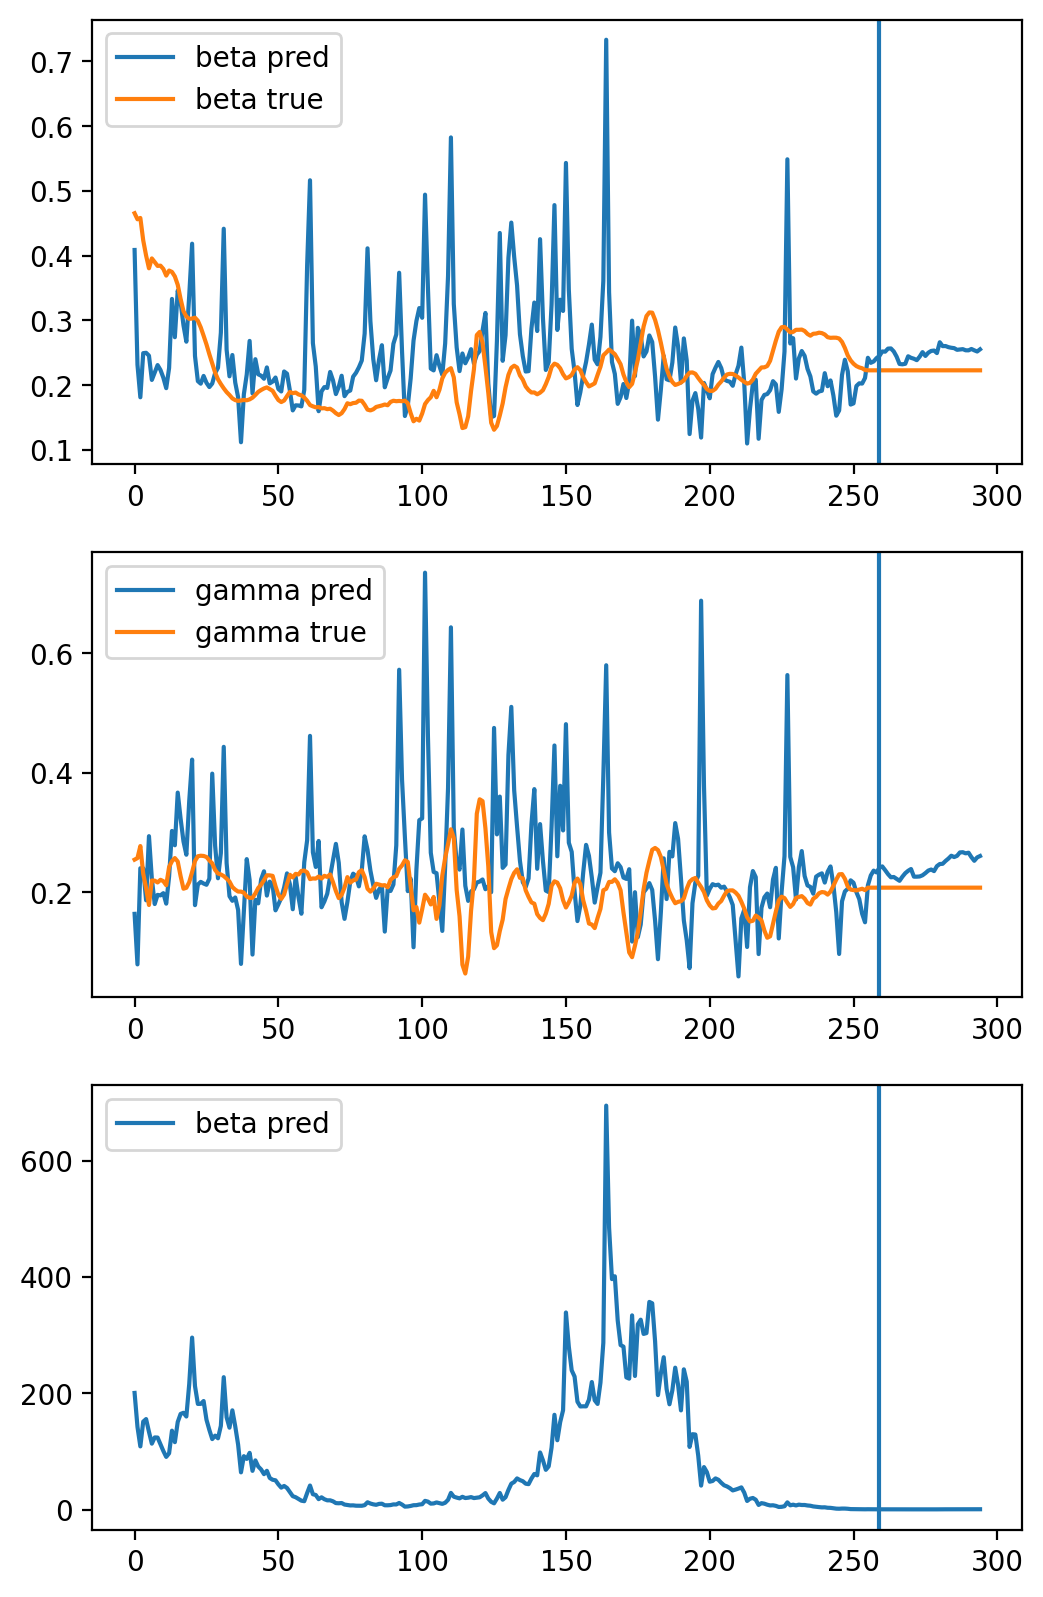

In [14]:
f,axs=plt.subplots(3,1,dpi=200,figsize=(6,10))
axs[0].plot(df_res.index,df_res.beta_pred,label='beta pred')
axs[0].plot(df_res.index,df_res.beta_true,label='beta true')
axs[1].plot(df_res.index,df_res.gamma_pred,label='gamma pred')
axs[1].plot(df_res.index,df_res.gamma_true,label='gamma true')
axs[2].plot(df_res.index,df_res.PredictedDailyNewCases,label='beta pred')
#axs[2].plot(df_res.index,df_res.beta_true,label='beta true')
for ax in axs:
    ax.legend()
    ax.axvline(train_lim)